In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.datasets import cifar10
from keras import layers, Input
import numpy as np
from keras.models import Sequential

# Local imports:
import sys
sys.path.append("../../Code")
from utils import show_train_history

2024-02-26 08:21:01.471210: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 08:21:01.491330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 08:21:01.491351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 08:21:01.492106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 08:21:01.496344: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load the ResNet50 model
# base_model = ResNet50(weights='imagenet', input_shape=(64, 64, 3), include_top=False)
base_model = ResNet50(weights='imagenet', input_shape=(32, 32, 3), include_top=False)

# Remove the last layer from the base model
base_model.layers.pop()

# Create a Sequential model
model = Sequential()

# Add the ResNet50 base model to the Sequential model
model.add(base_model)

# Flatten the output of the ResNet50 model
model.add(layers.Flatten())

# Add Batch Normalization for stabilization

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())

# Dropout for better generalization
model.add(layers.Dropout(0.5))

# Add a Dense layer with 10 units (assuming 10 classes) and softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Display the model summary
model.summary()

2024-02-26 08:21:02.474621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 08:21:02.495544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 08:21:02.495640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

In [3]:
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
# Upsample the images to be 64x64:
# x_train = np.array([image.array_to_img(x, scale=False).resize((64, 64)) for x in x_train])
# x_test = np.array([image.array_to_img(x, scale=False).resize((64, 64)) for x in x_test])

# Preprocess the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(x_train.shape)

(50000, 32, 32, 3)


In [4]:
# Train the model
# Adam with decay:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

initial_lr = 0.002
def schedule(epoch):
    if epoch < 5:
        return 0.002
    if epoch < 10:
        return 0.0006
    if epoch < 20:
        return 0.0002
    if epoch < 30:
        return 0.00006
    if epoch < 40:
        return 0.00002
    return 0.000006
optimizer = Adam(learning_rate=initial_lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

num_val = int(0.1 * x_train.shape[0])
x_val, y_val = x_train[:num_val], y_train[:num_val]

history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                     epochs=50, #validation_split=0.2,
                     validation_data=(x_val, y_val),
                    callbacks=[LearningRateScheduler(schedule)])


Epoch 1/50


2024-02-26 08:21:09.411006: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-26 08:21:12.053581: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f25c99dd3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-26 08:21:12.053599: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-26 08:21:12.056355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708953672.094770  140703 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 37s 47ms/step - loss: 1.7135 - accuracy: 0.4255 - val_loss: 10.4713 - val_accuracy: 0.3118 - lr: 0.0020
Epoch 2/50
391/391 [==============================] - 10s 26ms/step - loss: 1.3500 - accuracy: 0.5533 - val_loss: 1.5671 - val_accuracy: 0.5072 - lr: 0.0020
Epoch 3/50
391/391 [==============================] - 10s 26ms/step - loss: 1.3288 - accuracy: 0.5552 - val_loss: 2.4862 - val_accuracy: 0.4306 - lr: 0.0020
Epoch 4/50
391/391 [==============================] - 10s 26ms/step - loss: 1.1084 - accuracy: 0.6264 - val_loss: 1.0332 - val_accuracy: 0.6696 - lr: 0.0020
Epoch 5/50
391/391 [==============================] - 10s 26ms/step - loss: 0.9899 - accuracy: 0.6617 - val_loss: 0.8676 - val_accuracy: 0.6996 - lr: 0.0020
Epoch 6/50
391/391 [==============================] - 10s 26ms/step - loss: 0.7820 - accuracy: 0.7310 - val_loss: 0.6590 - val_accuracy: 0.7744 - lr: 6.0000e-04
Epoch 7/50
391/391 [==============================] - 9s 24ms/st

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


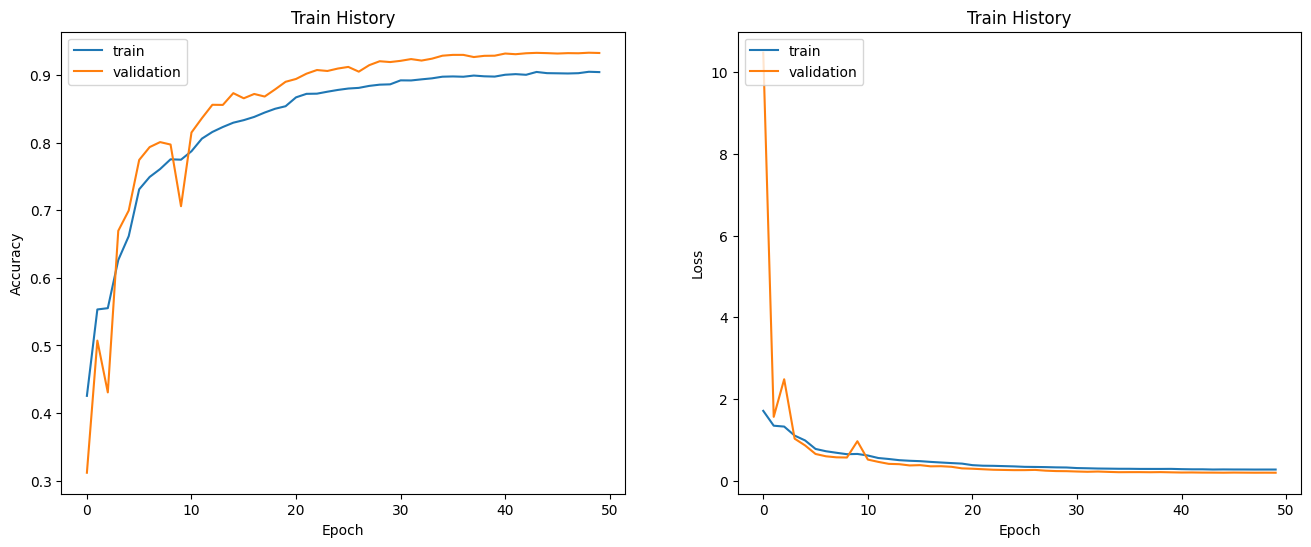

In [7]:
show_train_history(history, use_log=False)

In [8]:
# run on the test set:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.5349 - accuracy: 0.8352


In [9]:
test_acc

0.8352000117301941